In [ ]:
# !pip install -U datasets

In [ ]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.8 MB/s eta 0:00:00


# Setup

## Imports, Load Sampled MJSynth, Setup Drive and Wandb

In [ ]:
import os
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import wandb

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import CosineAnnealingLR

import Levenshtein
from Levenshtein import distance as levenshtein_distance

from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
from tqdm import tqdm
from difflib import SequenceMatcher
from itertools import groupby
from datasets import load_dataset
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


## Configs

In [ ]:
num_images = 25000
model_selected = 2  # 1: CNN + BiLSTMS
                    # 2: CNN + Attention

## Utility functions

In [ ]:
# Utility function: Greedy CTC decoder to convert model output logits to readable text sequences
def ctc_decoder(logits, char_list):
    """
    Decodes logits using greedy CTC decoding by collapsing repeated characters and removing blanks.
    Args:
        logits: Tensor of shape (T, B, C) — time, batch, classes
        char_list: list of characters (vocab)
    Returns:
        List[str]: decoded strings for each sample in the batch
    """
    if logits.ndim == 3 and logits.shape[0] != logits.size(1):
        pass  # shape validation; no operation needed here

    preds = torch.argmax(logits, dim=2)  # take most probable class at each timestep → [T, B]
    preds = preds.permute(1, 0)  # transpose to [B, T] for easier iteration per sample

    blank_idx = len(char_list)  # index used to represent the CTC blank token
    results = []
    for seq in preds:
        prev = None
        chars = []
        for idx in seq.tolist():
            # skip if character is blank or repeated
            if idx != prev and idx != blank_idx:
                chars.append(char_list[idx])
            prev = idx
        results.append(''.join(chars))
    return results


# Utility function: Decodes a single ground truth tensor label into string format for comparison
def decode_label(tensor_label, char_list):
    """
    Converts a padded label tensor to string, ignoring blank tokens.
    """
    blank_idx = len(char_list)
    return ''.join(char_list[i] for i in tensor_label.tolist() if i != blank_idx)


# Utility function: Computes normalized edit distance between two strings as a similarity metric
def compute_edit_distance(pred, gt):
    return 1 - SequenceMatcher(None, pred, gt).ratio()


# Utility function: Calculates character-level accuracy across all predictions
def character_accuracy(preds, gts):
    """
    Returns the proportion of correctly predicted characters over all ground truths.
    """
    correct, total = 0, 0
    for p, g in zip(preds, gts):
        m = min(len(p), len(g))
        correct += sum(p[i] == g[i] for i in range(m))
        total += len(g)
    return correct / total if total else 0


# Utility function: Calculates word-level accuracy (exact match) across all predictions
def word_accuracy(preds, gts):
    """
    Returns the proportion of completely correct word predictions.
    """
    correct = sum(p == g for p, g in zip(preds, gts))
    return correct / len(gts) if gts else 0


# Utility function: Visualizes sample predictions vs ground truths with decoded text and accuracy metrics
def visualize_predictions(model, dataset, char_list, num_samples=4):
    """
    Displays a few random samples with their ground truth and predicted text for quick qualitative evaluation.
    """
    model.eval()
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=num_samples, shuffle=True,
        collate_fn=TextRecognitionDataset.custom_collate_fn
    )
    images, labels = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        logits = model(images)  # model forward pass, expected shape [T, B, C]
        print("Raw logits sample slice:", logits[:5, 0, :10])  # inspect first few timesteps and classes
        preds = ctc_decoder(logits, char_list)

    gts = [decode_label(lbl, char_list) for lbl in labels]

    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        img = images[i].cpu().squeeze().numpy()
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"GT:{gts[i]}\nPR:{preds[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("\nSample Metrics:")
    print(f"Char Acc: {character_accuracy(preds, gts):.4f}")
    print(f"Word Acc: {word_accuracy(preds, gts):.4f}")


# Utility function: Counts total number of trainable parameters in the model for model size evaluation
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Utility function: Computes Character Error Rate (CER) as total edit distance normalized by total GT characters
def character_error_rate(preds, gts):
    total_edits, total_chars = 0, 0
    for p, g in zip(preds, gts):
        total_edits += levenshtein_distance(p, g)
        total_chars += len(g)
    return total_edits / total_chars if total_chars else 0


# Utility function: Computes word-level accuracy allowing up to k character differences (edit distance tolerance)
def word_accuracy_at_k(preds, gts, k):
    correct = sum(levenshtein_distance(p, g) <= k for p, g in zip(preds, gts))
    return correct / len(gts) if gts else 0


## Load Dataset into Drive

In [ ]:
# # Load MJSynth dataset (non-streaming)
# ds = load_dataset("priyank-m/MJSynth_text_recognition", split="train")

# # Shuffle and select num_images samples
# sampled = ds.shuffle(seed=42).select(range(num_images))
# assert len(sampled) == num_images, f"Sampled {len(sampled)} images, expected {num_images}"

# # Define output paths with versioning
# base_dir = "/content/drive/MyDrive/mjsynth_sampled"
# images_dir = os.path.join(base_dir, "images")
# os.makedirs(images_dir, exist_ok=True)

# label_txt_path = os.path.join(base_dir, f"label_{num_images}.txt")

# # Save sampled images and label file
# with open(label_txt_path, "w") as f:
#     for idx, item in enumerate(sampled):
#         image: Image.Image = item['image']
#         label = item['label']

#         filename = f"img_{idx:05d}.jpg"
#         full_img_path = os.path.join(images_dir, filename)
#         relative_path = os.path.relpath(full_img_path, base_dir)

#         if not os.path.exists(full_img_path):
#             image.save(full_img_path)

#         f.write(f"{relative_path}\t{label}\n")


# Pre - Processing

In [ ]:
class TextRecognitionDataset(Dataset):
    """
    Custom dataset class for OCR text recognition.
    Loads image paths and labels from a file, processes images, encodes labels into integers.
    """

    def __init__(self, label_file, transform=None, char_list=None, max_label_len=None):
        """
        Initializes the dataset by loading file paths and labels.

        Args:
            label_file: Path to label.txt containing image paths and labels separated by tab.
            transform: torchvision transforms to apply to each image.
            char_list: predefined character vocabulary. If None, built from dataset labels.
            max_label_len: maximum label length for padding. If None, inferred from dataset.
        """
        # Load image paths and labels from file into a DataFrame
        self.samples = pd.read_csv(label_file, sep="\t", names=["img_path", "label"])
        self.samples.dropna(inplace=True)  # remove rows with missing labels

        self.transform = transform
        self.label_file = label_file

        # Build vocabulary if not provided
        if char_list is None:
            all_text = "".join(self.samples["label"])
            self.char_list = sorted(set(all_text))  # sorted list of unique characters in dataset
        else:
            self.char_list = char_list

        # Determine maximum label length (used for padding)
        self.max_label_len = max_label_len or self.samples["label"].str.len().max()

        # Pre-encode all labels to integer sequences
        self.encoded_labels = self.samples["label"].apply(self.encode_label)

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Loads and returns a single sample (image tensor and encoded label tensor).
        """
        img_path = self.samples.iloc[idx]["img_path"]
        label = self.encoded_labels.iloc[idx]

        # Build full image path relative to label file directory
        image_path = os.path.join(os.path.dirname(self.label_file), img_path)
        image = Image.open(image_path).convert("L")  # load as grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

    def encode_label(self, text):
        """
        Encodes a string label into a list of integer indices based on the character vocabulary.
        Pads the encoded label with blank indices to match max_label_len.
        """
        label = [self.char_list.index(c) for c in text]
        padded = label + [len(self.char_list)] * (self.max_label_len - len(label))
        return padded

    def get_vocab(self):
        """
        Returns the character vocabulary used for encoding.
        """
        return self.char_list

    def get_max_label_len(self):
        """
        Returns the maximum label length (after padding).
        """
        return self.max_label_len

    @staticmethod
    def custom_collate_fn(batch):
        """
        Custom collate function for DataLoader.
        Stacks images into a batch tensor and converts list of encoded labels into tensor.
        """
        images, labels = zip(*batch)
        images = torch.stack(images, 0)
        labels = torch.tensor(labels, dtype=torch.long)
        return images, labels


# Data Loader

In [ ]:
# Define Image Transformations to ensure same image size
transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor()
])

# Load dataset
label_file = f"/content/drive/MyDrive/mjsynth_sampled/label_{num_images}.txt"
dataset = TextRecognitionDataset(label_file, transform=transform)

vocab = dataset.get_vocab()
vocab_size = len(vocab)
blank_token = vocab_size  # assign blank token index

# Example sample
image, label = dataset[0]
print(image.shape)
print(label) # Padded encoded label

torch.Size([1, 32, 128])
[12, 24, 30, 23, 29, 14, 27, 29, 14, 23, 24, 27, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62]


## Example image and its label

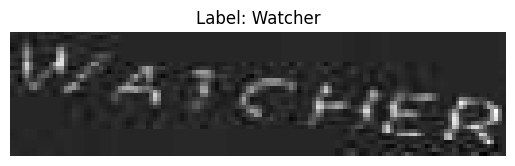

In [ ]:
# Get a sample
image_tensor, encoded_label = dataset[3]  # You can change the index here (e.g., dataset[10])

# Convert tensor to image (CHW to HWC)
image_np = image_tensor.squeeze().numpy()  # Shape: [32, 128] for grayscale

pad_token = vocab_size  # padding uses this value

# Remove padding tokens and decode
decoded_label = ''.join([vocab[i] for i in encoded_label if i != pad_token])

# Show the image
plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {decoded_label}")
plt.axis('off')
plt.show()


## Train-Test split

In [ ]:
# Split the dataset into training and validation sets (70% train, 30% val)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define DataLoader for training set with shuffling for batching and generalisation
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=TextRecognitionDataset.custom_collate_fn
)

# Define DataLoader for validation set without shuffling
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=TextRecognitionDataset.custom_collate_fn
)


# Model

## CNN

In [ ]:
class ConvBlock(nn.Module):
    """
    Basic convolutional block with optional residual connection.
    Consists of Conv2d -> BatchNorm -> ReLU layers.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, residual=False):
        super().__init__()
        self.residual = residual and in_channels == out_channels  # enable residual only if dimensions match
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.conv(x)
        if self.residual:
            return out + x  # add input for residual connection
        return out


def build_cnn(nc):
    """
    Builds a feature extraction CNN to reduce input height to 1 for CRNN models.

    Args:
        nc: number of input channels (e.g. 1 for grayscale images)
    Returns:
        nn.Sequential containing convolutional feature extractor

    Input shape: (B, 1, H, W)
    Output shape: (B, 512, 1, W')
    """
    layers = [
        ConvBlock(nc, 64, 3, 1, 1),
        nn.MaxPool2d(2, 2),  # halve height

        ConvBlock(64, 128, 3, 1, 1),
        nn.MaxPool2d(2, 2),  # halve height again

        ConvBlock(128, 256, 3, 1, 1),
        ConvBlock(256, 256, 3, 1, 1),  # second 256 block; residual disabled to reduce memory

        nn.MaxPool2d((2, 1)),  # reduce height further, keep width

        ConvBlock(256, 512, 3, 1, 1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),

        nn.MaxPool2d((2, 1)),  # final pooling along height

        nn.AdaptiveAvgPool2d((1, None))  # ensure output height = 1, width preserved
    ]

    return nn.Sequential(*layers)


## CRNN

### Option 1: CNN + BiLSTM

In [ ]:
class CRNN_BiLSTM(nn.Module):
    """
    CRNN model with CNN feature extractor and bidirectional LSTM for sequence modeling.
    Suitable for OCR tasks with CTC decoding.
    """
    def __init__(self, img_h, nc, nclass, nh=256, num_rnn_layers=2):
        """
        Args:
            img_h: input image height (unused, kept for compatibility)
            nc: number of input channels (1 for grayscale)
            nclass: number of output classes (characters + blank)
            nh: hidden size of LSTM
            num_rnn_layers: number of stacked LSTM layers
        """
        super().__init__()

        self.cnn = build_cnn(nc)

        self.rnn = nn.LSTM(
            input_size=512,       # CNN output channels
            hidden_size=nh,
            num_layers=num_rnn_layers,
            bidirectional=True    # captures both left-to-right and right-to-left dependencies
        )
        self.embedding = nn.Linear(nh * 2, nclass)  # combines both directions to output class logits

    def forward(self, x):
        conv = self.cnn(x)  # shape: (B, 512, 1, W)
        b, c, h, w = conv.size()
        assert h == 1, f"Expected height=1 after CNN, got {h}"

        conv = conv.squeeze(2).permute(2, 0, 1)  # reshape to (W, B, 512) for LSTM input

        rnn_out, _ = self.rnn(conv)
        out = self.embedding(rnn_out)  # shape: (W, B, nclass)
        return out

### Option 2: CNN + Attention

In [ ]:
class CRNN_Attention(nn.Module):
    """
    CRNN model with CNN feature extractor and multi-head self-attention for sequence modeling.
    Uses causal mask to preserve autoregressive property required by CTC decoding.
    """
    def __init__(self, img_h, nc, nclass, nh=256, num_heads=1, dropout=0.1):
        """
        Args:
            img_h: input image height (unused, kept for compatibility)
            nc: number of input channels
            nclass: number of output classes
            nh: hidden size of attention
            num_heads: number of attention heads
            dropout: dropout rate
        """
        super().__init__()

        self.cnn = build_cnn(nc)
        self.proj = nn.Linear(512, nh)  # project CNN output channels to attention hidden size

        self.norm1 = nn.LayerNorm(nh)
        self.attn = nn.MultiheadAttention(embed_dim=nh, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Linear(nh, nclass)

    def forward(self, x):
        conv = self.cnn(x)  # (B, 512, 1, W)
        b, c, h, w = conv.size()
        assert h == 1, f"Expected height=1 after CNN, got {h}"

        conv = conv.squeeze(2).permute(0, 2, 1)   # reshape to (B, W, 512)
        conv_proj = self.proj(conv)               # project to (B, W, nh)

        x_norm = self.norm1(conv_proj)            # layer normalization

        seq_len = conv_proj.size(1)
        # Create causal mask to prevent attention to future positions
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)

        attn_out, _ = self.attn(x_norm, x_norm, x_norm, attn_mask=mask)  # self-attention output (B, W, nh)
        attn_out = self.dropout(attn_out)

        x_res = conv_proj + attn_out             # add residual connection
        out = self.embedding(x_res)              # final class logits (B, W, nclass)
        return out.permute(1, 0, 2)              # reshape to (W, B, nclass) for CTC decoding

# Training

In [ ]:
# Define model architecture name and WandB experiment name based on selected model
if model_selected == 1:
    architecture = "CRNN (CNN + BiLSTM + CTC)"
    wandb_name = f"Image2Seq: CRNN-BiLSTM-{num_images}_imgs"
    artifact_name = f"best_model_CRNN_BiLSTM_{num_images}_imgs.pth"
else:
    architecture = "CRNN (CNN + Attention + CTC)"
    wandb_name = f"Image2Seq: CRNN-Attention-{num_images}_imgs"
    artifact_name = f"best_model_CRNN_Attention_{num_images}_imgs.pth"

# Configuration dictionary for WandB
config = {
    "epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": architecture
}

# Initialize WandB logging
wandb.init(project="OCR", name=wandb_name, config=config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adriabuil (adriabuil-upc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Loss function and optimizer

In [ ]:
# Instantiate model based on selected architecture
if model_selected == 1:
    model = CRNN_BiLSTM(
        img_h=32,
        nc=1,  # number of input channels (1 for grayscale)
        nclass=vocab_size + 1,  # +1 to include blank token
        nh=256,
        num_rnn_layers=2
    ).to(device)
else:
    model = CRNN_Attention(
        img_h=32,
        nc=1,
        nclass=vocab_size + 1,
        nh=256,
        num_heads=1
    ).to(device)

# Define CTC Loss function for sequence alignment without explicit segmentation
criterion = nn.CTCLoss(blank=blank_token, zero_infinity=True)

# Define optimizer for model training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler to reduce LR every 5 epochs by factor 0.5 for stable convergence
scheduler = CosineAnnealingLR(optimizer, T_max=config["epochs"])

## Train one epoch

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    """
    Trains the model for one epoch on the provided dataloader.

    Args:
        model: PyTorch model to train
        dataloader: DataLoader providing (images, labels) batches
        optimizer: optimizer used for weight updates
        criterion: loss function (CTC Loss)

    Returns:
        avg_loss: average training loss over the epoch
    """
    model.train()
    epoch_loss = 0

    # Wrap dataloader with tqdm to show progress bar during training
    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = model(imgs)  # output logits [T, B, C]
        preds_log_softmax = preds.log_softmax(2)  # apply log-softmax over class dimension for CTC Loss

        # Define input lengths (all equal to T since CNN output has fixed temporal length)
        input_lengths = torch.full(
            (preds.size(1),), preds.size(0), dtype=torch.long
        ).to(device)

        # Define target lengths by counting non-padding tokens in each label
        target_lengths = torch.tensor(
            [len(l[l != vocab_size]) for l in labels],
            dtype=torch.long
        ).to(device)

        # Compute CTC loss between predicted sequence logits and ground truth labels
        loss = criterion(preds_log_softmax, labels, input_lengths, target_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)

    # Log average training loss to wandb for monitoring
    wandb.log({"Train loss": avg_loss})

    return avg_loss

## Sanity-check before training

== Dataset Samples ==
Sample 0: image shape=torch.Size([1, 32, 128]), label indices=[12, 24, 30, 23, 29, 14, 27, 29, 14, 23, 24, 27, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62]
Decoded label: COUNTERTENOR


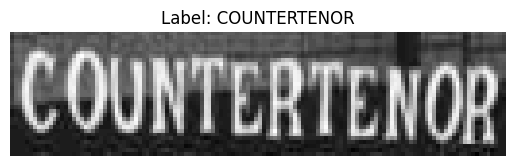

Sample 1: image shape=torch.Size([1, 32, 128]), label indices=[25, 53, 44, 48, 36, 38, 60, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62]
Decoded label: Primacy


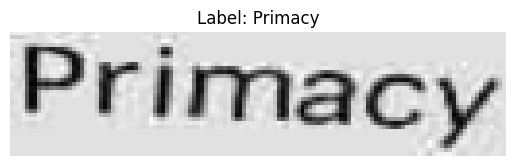


== Dataloader Batch Validation ==
Labels max value in batch: 62
Allowed max index (blank token): 62


In [ ]:
def validate_dataset_and_loader(dataset, dataloader, vocab, num_samples):
    """
    Performs two essential sanity checks before training:

    1. Displays a few samples from the dataset with image shapes, encoded labels, and decoded text
       to verify correct loading, encoding, and image preprocessing.
    2. Validates a batch from the DataLoader to ensure that all label indices are within
       the valid CTC range (including the blank token).

    Args:
        dataset: your dataset object supporting indexing
        dataloader: your DataLoader object
        vocab: list of characters representing your vocabulary (excluding blank token)
        num_samples: number of samples to visualize from the dataset
    """

    print("== Dataset Samples ==")
    for i in range(num_samples):
        img, encoded_label = dataset[i]
        print(f"Sample {i}: image shape={img.shape}, label indices={encoded_label}")

        # Decode label indices into string, skipping blank padding
        decoded_label = ''.join([vocab[idx] for idx in encoded_label if idx != blank_token])
        print(f"Decoded label: {decoded_label}")

        plt.imshow(img.squeeze().numpy(), cmap='gray')
        plt.title(f"Label: {decoded_label}")
        plt.axis('off')
        plt.show()

    print("\n== Dataloader Batch Validation ==")
    for imgs, labels in dataloader:
        max_label = labels.max().item()
        print(f"Labels max value in batch: {max_label}")
        print(f"Allowed max index (blank token): {blank_token}")

        # Validate that no label index exceeds blank token index
        assert max_label <= blank_token, \
            f"Label index {max_label} out of range! Must be <= {blank_token} (vocab size: {vocab_size})"
        break  # only check first batch to save time

# Example call before training to ensure data integrity
validate_dataset_and_loader(dataset, train_loader, vocab, num_samples=2)

## Training Loop

In [ ]:
best_loss = float('inf')  # track best validation loss for model checkpointing

# Training loop over epochs
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch + 1}/{config['epochs']}")

    # === Training ===
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0
    all_preds, all_gts = [], []  # store all predictions and GTs for metric computation

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)  # model forward pass
            preds_log_softmax = preds.log_softmax(2)

            # Define input lengths (all equal to T)
            input_lengths = torch.full(
                (preds.size(1),), preds.size(0), dtype=torch.long
            ).to(device)

            # Define target lengths (exclude padding tokens)
            target_lengths = torch.tensor(
                [len(l[l != blank_token]) for l in labels],
                dtype=torch.long
            ).to(device)

            # Compute CTC loss
            loss = criterion(preds_log_softmax, labels, input_lengths, target_lengths)
            val_loss += loss.item()

            # Decode predictions and ground truths for metrics
            batch_preds = ctc_decoder(preds, vocab)
            batch_gts = [decode_label(lbl, vocab) for lbl in labels]

            all_preds += batch_preds
            all_gts += batch_gts

    val_loss /= len(val_loader)
    print(f"Val Loss: {val_loss:.4f}")

    # === Character Error Rate (CER) ===
    cer = character_error_rate(all_preds, all_gts)
    print(f"CER: {cer:.4f}")

    # === Word Accuracy@k ===
    acc_k_dict = {}
    for k in [0, 1, 2]:
        acc_k = word_accuracy_at_k(all_preds, all_gts, k)
        acc_k_dict[f"Word Accuracy @{k}"] = acc_k
        print(f"Word Accuracy @{k}: {acc_k:.4f}")

    # === Learning Rate Logging ===
    lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {lr:.6f}")

    # === Log all metrics to WandB ===
    wandb.log({
        "epoch": epoch + 1,
        "Train Loss": train_loss,
        "Val Loss": val_loss,
        "CER": cer,
        **acc_k_dict,
        "LR": lr,
    })

    # === Step the learning rate scheduler ===
    scheduler.step()

    # === Save best model checkpoint ===
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), artifact_name)

        # Save best model as a wandb artifact for experiment tracking
        artifact = wandb.Artifact(artifact_name, type='model')
        artifact.add_file(artifact_name)
        wandb.log_artifact(artifact)




Epoch 1/15


Training:   2%|▏         | 9/547 [01:13<1:09:21,  7.73s/it]

# Inference & Evaluation

In [ ]:
visualize_predictions(model, dataset, dataset.get_vocab(), num_samples=10)

## Model Parameters

In [ ]:
num_params = count_parameters(model)
print(f"Number of model parameters: {num_params:,}")
wandb.log({"num_params": num_params})

## Final Evaluation

In [ ]:
def final_precision_recall_auc(model, val_loader, char_list):
    """
    Computes Precision-Recall curve and AUC, logs results to wandb,
    and saves the PR plot as an image artifact.
    """
    model.eval()
    y_true, y_scores = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=2)

            preds = ctc_decoder(logits, char_list)
            gts = [decode_label(lbl, char_list) for lbl in labels]

            pred_ids = torch.argmax(logits, dim=2)
            pred_probs = probs.gather(2, pred_ids.unsqueeze(2)).squeeze(2)

            pred_probs = pred_probs.permute(1,0)
            mean_confidences = pred_probs.mean(dim=1).cpu().numpy()

            y_true.extend([int(p==g) for p,g in zip(preds,gts)])
            y_scores.extend(mean_confidences)

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    auc_score = auc(recall, precision)

    # Plot and save the Precision-Recall curve
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, marker='.', label=f'AUC={auc_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # Save plot to temporary file and log as wandb artifact (image)
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plt.savefig(tmpfile.name)
        wandb.log({"Precision-Recall Curve": wandb.Image(tmpfile.name)})
    plt.close()

    # Log AUC value to wandb as a time-series metric for line chart display
    wandb.log({
        "Precision-Recall AUC": auc_score
    })

    print(f"Final Precision-Recall AUC: {auc_score:.4f}")
    return auc_score



def final_roc_auc(model, val_loader, char_list):
    """
    Computes ROC curve and AUC, logs results to wandb,
    and saves the ROC plot as an image artifact.
    """
    model.eval()
    y_true, y_scores = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=2)

            preds = ctc_decoder(logits, char_list)
            gts = [decode_label(lbl, char_list) for lbl in labels]

            pred_ids = torch.argmax(logits, dim=2)
            pred_probs = probs.gather(2, pred_ids.unsqueeze(2)).squeeze(2)

            pred_probs = pred_probs.permute(1,0)
            mean_confidences = pred_probs.mean(dim=1).cpu().numpy()

            y_true.extend([int(p==g) for p,g in zip(preds,gts)])
            y_scores.extend(mean_confidences)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot and save the ROC curve
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, marker='.', label=f'AUC={roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Save plot to temporary file and log as wandb artifact (image)
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plt.savefig(tmpfile.name)
        wandb.log({"ROC Curve": wandb.Image(tmpfile.name)})
    plt.close()

    # Log AUC value to wandb
    wandb.log({
        "ROC AUC": roc_auc
    })

    print(f"Final ROC AUC: {roc_auc:.4f}")
    return roc_auc

In [ ]:
final_precision_recall_auc(model, val_loader, vocab)

In [ ]:
final_roc_auc(model, val_loader, vocab)